# Exploring the Alzheimer's prediction dataset from [kaggle](https://www.kaggle.com/datasets/ankushpanday1/alzheimers-prediction-dataset-global)

### Loading the Dataset

In [3]:
import pandas as pd

alzheimers = pd.read_csv("data/alzheimers.csv")

### Summary Statistics

In [4]:
display(alzheimers.describe().style.set_caption("Numerical Columns"))
display(alzheimers.select_dtypes(include="object").describe().style.set_caption("Categorical Columns"))
display(alzheimers.info())

,Age,Education Level,BMI,Cognitive Test Score
count,74283.000000,74283.000000,74283.000000,74283.000000
mean,71.964703,9.487514,26.780639,64.654241
std,12.980748,5.757020,4.764679,20.153247
min,50.000000,0.000000,18.500000,30.000000
25%,61.000000,4.000000,22.700000,47.000000
50%,72.000000,9.000000,26.800000,65.000000
75%,83.000000,14.000000,30.900000,82.000000
max,94.000000,19.000000,35.000000,99.000000


,Country,Gender,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,Family History of Alzheimer’s,Depression Level,Sleep Quality,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
count,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283
unique,20,2,3,3,3,2,2,2,2,3,3,3,3,3,3,2,3,3,3,2,2
top,Brazil,Female,High,Current,Never,No,No,Normal,No,Medium,Good,Average,High,Unemployed,Single,No,Medium,Low,Medium,Rural,No
freq,3839,37249,24853,24915,24865,59527,52134,51973,52004,24843,25145,24917,24906,24801,25169,59561,24859,24873,24886,37203,43570


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

None

This dataset appears to be very clean.
- No missing values, the row counts for each attribute remain consistent for all.
- Data types appear as expected.
- Frequency counts for categorical variables show a good distribution for each.

### Univariate Analysis

Linear correlation analysis:

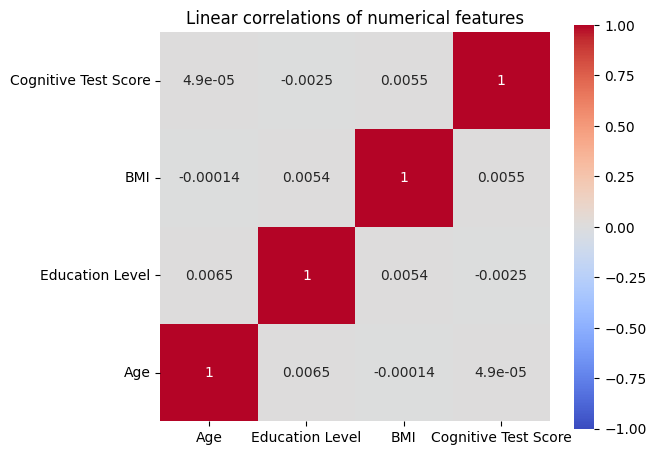

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(alzheimers.select_dtypes(include='number').corr().iloc[::-1], vmin=-1, vmax=1, cmap='coolwarm', annot=True, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("Linear correlations of numerical features")
plt.tight_layout()
plt.show()

# Preprocessing

## Standardization + Ordinal Encoding + OneHot Encoding

Also changed whitespace to _, and removed apostraphes.

In [7]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numerical_columns = alzheimers.select_dtypes(include = "number").columns

ordinal_columns = {
    'Physical Activity Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Alcohol Consumption': {'Never': 0, 'Occasionally': 1, 'Regularly': 2},
    'Cholesterol Level': {'Normal': 0, 'High': 1},
    'Depression Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Sleep Quality': {'Poor': 0, 'Average': 1, 'Good': 2},
    'Dietary Habits': {'Unhealthy': 0, 'Average': 1, 'Healthy': 2},
    'Air Pollution Exposure': {'Low': 0, 'Medium': 1, 'High': 2},
    'Social Engagement Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Income Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Stress Levels': {'Low': 0, 'Medium': 1, 'High': 2},
}

non_binary_nominal_columns = [
    'Country',
    'Smoking Status',
    'Employment Status',
    'Marital Status',
]

binary_nominal_columns = [
    'Gender',
    'Diabetes',
    'Hypertension',
    'Family History of Alzheimer’s',
    'Genetic Risk Factor (APOE-ε4 allele)',
    'Urban vs Rural Living',
    'Alzheimer’s Diagnosis'
]

standard_scaler_transformer = StandardScaler()

def get_ordinal_categories(mapping):
    return [list(mapping[col].keys()) for col in mapping]

ordinal_column_names = list(ordinal_columns.keys())
ordinal_categories = get_ordinal_categories(ordinal_columns)

ordinal_transformer = OrdinalEncoder(categories=ordinal_categories)

onehot_nonbinary_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
onehot_binary_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore')

preprocessor = ColumnTransformer( # Using ColumnTransformer to just conglomerate the different transformers used, not nessecary
    transformers=[
        ("numerical", standard_scaler_transformer, numerical_columns),
        ("ordinal", ordinal_transformer, ordinal_column_names),
        ("onehot_nonbinary", onehot_nonbinary_transformer, non_binary_nominal_columns),
        ("onehot_binary", onehot_binary_transformer, binary_nominal_columns),
    ],
    remainder="passthrough"
)

alzheimers_encoded = preprocessor.fit_transform(alzheimers)

# --- After transformation, we lose our feature names, we can add them back in:

# non-binary nominal feature names
onehot_nonbinary_encoder = preprocessor.named_transformers_["onehot_nonbinary"]
nonbinary_feature_names = onehot_nonbinary_encoder.get_feature_names_out(non_binary_nominal_columns)

# binary nominal feature names
onehot_binary_encoder = preprocessor.named_transformers_["onehot_binary"]
binary_feature_names = onehot_binary_encoder.get_feature_names_out(binary_nominal_columns)

all_feature_names = (
    list(numerical_columns)
    + list(ordinal_column_names)
    + list(nonbinary_feature_names)
    + list(binary_feature_names)
)
alzheimers_encoded = pd.DataFrame(alzheimers_encoded, columns=all_feature_names)

# Replace whitespace with underscore and remove weird apostraphe
alzheimers_encoded.columns = (
    alzheimers_encoded.columns
    .str.replace(r"\s+", "_", regex=True)
    .str.replace("’", "", regex=False)
)
alzheimers_encoded

alzheimers_encoded.head()

,Age,Education_Level,BMI,Cognitive_Test_Score,Physical_Activity_Level,Alcohol_Consumption,Cholesterol_Level,Depression_Level,Sleep_Quality,Dietary_Habits,...,Employment_Status_Unemployed,Marital_Status_Single,Marital_Status_Widowed,Gender_Male,Diabetes_Yes,Hypertension_Yes,Family_History_of_Alzheimers_Yes,Genetic_Risk_Factor_(APOE-ε4_allele)_Yes,Urban_vs_Rural_Living_Urban,Alzheimers_Diagnosis_Yes
0,1.389398,-1.474299,1.305314,1.257660,1.0,1.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.002719,-0.432087,0.654689,0.017157,1.0,0.0,0.0,0.0,2.0,2.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.081247,1.652339,-0.814465,-1.074486,2.0,1.0,0.0,2.0,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.460997,1.304935,0.927532,0.811079,0.0,2.0,0.0,1.0,1.0,2.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.075808,-1.126895,0.675677,-0.776765,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Saving to CSV

In [8]:
alzheimers_encoded.to_csv("data/alzheimers_encoded.csv", index=False)

## Feature Selection

In [19]:
import pandas as pd

alzheimers_encoded = pd.read_csv("data/alzheimers_encoded.csv")

# Split features and target
numerical_data = alzheimers_encoded.drop(columns=["Alzheimers_Diagnosis_Yes"])
target = alzheimers_encoded['Alzheimers_Diagnosis_Yes']

Find the feature importance with random forest

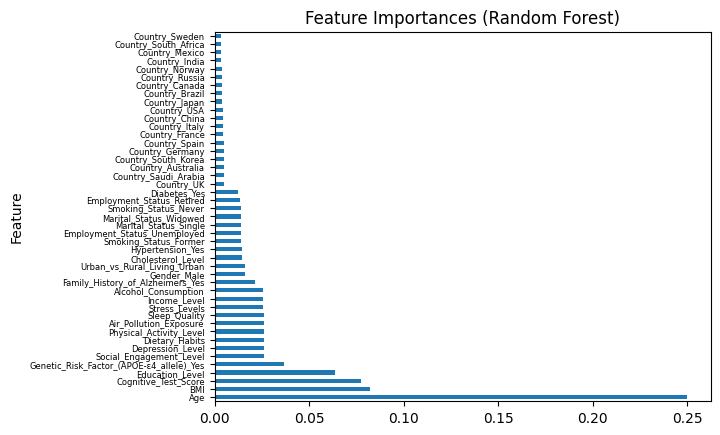

In [35]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

rf = RandomForestClassifier()
rf.fit(numerical_data, target)

importances = rf.feature_importances_
imp_df = pd.DataFrame({'Feature': numerical_data.columns, 'Importance': importances})
imp_df_sorted = imp_df.sort_values(by='Importance', ascending=False)

# Plot all the features with its importances
imp_df_sorted.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.tick_params(axis='y', labelsize=6)
plt.title('Feature Importances (Random Forest)')
plt.show()


# Modeling

In [20]:
import pandas as pd

alzheimers = pd.read_csv("data/alzheimers.csv")
alzheimers_encoded = pd.read_csv("data/alzheimers_encoded.csv")

numerical_data = alzheimers_encoded.drop(columns=["Alzheimers_Diagnosis_Yes"])
target = alzheimers_encoded['Alzheimers_Diagnosis_Yes']

### CV strategy functions

Currently only using basic train test split validation. TODO: implement more comprehensive k-fold strategies, such as stratified k-fold.

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np

def basic_tt_split_validation(X, y, model, train_size = 0.80):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = np.sum(predictions == y_test) / predictions.__len__()
    return accuracy

### Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
def random_forest_model_run():
    start_time = time.perf_counter()

    rf_classifier = RandomForestClassifier()

    # Currently just using numerical values
    numerical_data = alzheimers_encoded[numerical_columns.str.replace(r"\s+", "_", regex=True)]
    target = alzheimers_encoded['Alzheimers_Diagnosis_Yes']
    accuracy = basic_tt_split_validation(numerical_data, target, rf_classifier)

    end_time = time.perf_counter()

    print("Accuracy of RF model:", accuracy)
    print("Time taken:", end_time - start_time, "(s)")
random_forest_model_run()

Accuracy of RF model: 0.6767853537053241
Time taken: 11.767326599918306 (s)


### K-fold cross validation

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare for CV
k = 4
fold_size = len(numerical_data) // k

accuracies = []
coefficients = []

for i in range(k):
    start = i * fold_size
    end = start + fold_size if i < k - 1 else len(numerical_data)

    X_test = numerical_data.iloc[start:end]
    y_test = target.iloc[start:end]

    X_train = numerical_data.drop(numerical_data.index[start:end])
    y_train = target.drop(target.index[start:end])

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Store accuracy and coefficients
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    coefficients.append(model.coef_[0])

print("K-fold accuracies:", accuracies)
print("Average accuracy:", np.mean(accuracies))
print("Coefficients (per fold):")
for i, coef in enumerate(coefficients):
    print(f"Fold {i+1} coefficients: {coef}")


K-fold accuracies: [0.7110931610123856, 0.7128702207862143, 0.7118470651588584, 0.7241694933505627]
Average accuracy: 0.7149949850770052
Coefficients (per fold):
Fold 1 coefficients: [ 1.06602100e+00  1.40863385e-03  8.03808584e-03 -6.44953863e-03
  9.88571390e-03  1.70864048e-03 -1.99870455e-02  1.16779644e-02
 -1.32795140e-02 -9.11727060e-03 -1.13830727e-03 -8.59917513e-03
  3.45859074e-03  1.49321276e-02 -1.48193748e-01  4.13109284e-01
 -3.56850859e-01 -1.66060799e-01 -1.36454160e-01 -4.77830402e-02
  4.68948161e-01 -1.07479682e-01 -4.88255723e-01  3.98037998e-01
 -4.16250708e-01  5.12256779e-01 -9.01666723e-02  3.86741187e-01
 -4.56365584e-02 -8.88146807e-02 -4.14067081e-01 -8.47697619e-02
 -1.74528658e-01  8.40478150e-03  4.55617663e-03  3.50096241e-02
  1.80088200e-02 -2.10918426e-02 -2.74231064e-03 -4.56143082e-04
 -3.49534234e-03 -1.30708124e-02  8.33972620e-01  1.26413951e+00
 -1.24386644e-02]
Fold 2 coefficients: [ 1.06922131e+00 -9.69008056e-04 -6.02728593e-04  4.54400501e-0

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Set training rules (train control)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Naive Bayes
nb = GaussianNB()
nb_score = np.mean(cross_val_score(nb, numerical_data, target, cv=cv, scoring='accuracy'))
print("Naive Bayes Accuracy:", nb_score)

# LDA
lda = LinearDiscriminantAnalysis()
lda_score = np.mean(cross_val_score(lda, numerical_data, target, cv=cv, scoring='accuracy'))
print("LDA Accuracy:", lda_score)

# QDA
qda = QuadraticDiscriminantAnalysis()
qda_score = np.mean(cross_val_score(qda, numerical_data, target, cv=cv, scoring='accuracy'))
print("QDA Accuracy:", qda_score)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg_score = np.mean(cross_val_score(logreg, numerical_data, target, cv=cv, scoring='accuracy'))
print("Logistic Regression Accuracy:", logreg_score)

Naive Bayes Accuracy: 0.6378041257728634
LDA Accuracy: 0.7156012231342497
QDA Accuracy: 0.6419100151293345
Logistic Regression Accuracy: 0.7150896661618722


In [ ]:
# KNN
knn_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {'knn_n_neighbors': [3, 5, 7, 9, 11]}
grid_knn = GridSearchCV(knn_pipe, param_grid_knn, cv=cv, scoring='accuracy')
grid_knn.fit(numerical_data, target)

print("Best KNN Accuracy:", grid_knn.best_score_)
print("Best k:", grid_knn.best_params_['knn__n_neighbors'])

ValueError: Invalid parameter 'knn_n_neighbors' for estimator Pipeline(steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier())]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].